# Loading packages
If your conda environment is new, you can install packages using:  
`conda install numpy pytz ipywidgets xarray netcdf4`

In [3]:
import os
import re
import numpy as np
from datetime import datetime, timedelta
import pytz

# Downloading and reading image data

Downloading from AWS website: https://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi

List of available products and their identification codes: https://github.com/awslabs/open-data-docs/tree/main/docs/noaa/noaa-goes16

In [27]:
# You can create a list of number strings by using: [f"{i:02}" for i in range(13)]
destination_path = '.\\GOESimages\\'
bucket = 'noaa-goes16'
satellite = bucket[re.search('noaa-',bucket).end():]
day, month, year = '15', '06', '2023' # Date in dd/mm/yyyy format
hour = '17' # UTC, should be a string number between '00' and '23'
product=['ABI-L1b-RadF'] # Product to select
product0 = product[0]
domain = product0[-1]
channel=['C01','C02','C03'] # Number of band to select between 'C01' and 'C16'

FilePath = os.path.join(destination_path,satellite,year, month, day, product0,hour)
if ( product0[:-1] == "ABI-L1b-Rad") or (product0[:-1] == "ABI-L2-CMIP") :
    FilePath = os.path.join(FilePath,channel[0])
FilePath

'.\\GOESimages\\goes16\\2023\\06\\15\\ABI-L1b-RadF\\17\\C01'

In [6]:
import cartopy.io.shapereader as shpreader
import geopandas as gpd

# Define the path to the shapefile
# https://www.marineregions.org/downloads.php
# https://www.naturalearthdata.com/downloads/10m-cultural-vectors/
# shpfilename_countries = shpreader.natural_earth(resolution='10m',
#                                       category='cultural',
#                                       name='admin_0_countries')
# shpfilename_land = shpreader.natural_earth(resolution='10m',
#                                       category='cultural',
#                                       name='admin_0_boundary_lines_land')
# shpfilename_states = shpreader.natural_earth(resolution='10m',
#                                    category='cultural',
#                                    name='admin_1_states_provinces')
# Read in the shapefile as a GeoDataFrame
# gdf_countries = gpd.read_file(shpfilename_countries)
gdf_countries = gpd.read_file("./Boundaries/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")
gdf_maritime = gpd.read_file("./SeaLimits/World_EEZ_v11_20191118/eez_v11.shp")
gdf_states = gpd.read_file("./Boundaries/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")
# gdf_states = gpd.read_file(shpfilename_states)
# Filter the GeoDataFrame to keep only rows where adm1_code matches "PER"
gdf_peru_land = gdf_states[gdf_states["adm1_code"].str[:3] == "PER"]
gdf_peru_sea = gdf_maritime[gdf_maritime["TERRITORY1"] == "Peru"].iloc[[1]]
gdf_maritime = gdf_maritime[gdf_maritime["TERRITORY1"] != "Peru"]

## Using goespy package
GitHub: https://github.com/spestana/goes-py
You can install goespy package by running:  
`git clone https://github.com/palexandremello/goes-py.git`  
`cd goes-py`  
`python setup.py install`  
If you have an error like ImportError: cannot import name **'DEPRECATED_SERVICE_NAMES' from 'botocore.docs' (c:\Users\germa\anaconda3\envs\satimg\lib\site-packages\botocore\docs\_\_init\_\_.py)**, you may need to run:  
`pip install boto3`  
`pip install botocore`

In [7]:
import goespy


======================================== goes-py =========================================
 A Python package can be useful to download dataset from goes satellite on AWS  0.2.1v


In [8]:
from goespy.Downloader import ABI_Downloader
help(ABI_Downloader)
ABI = ABI_Downloader(destination_path,bucket,year,month,day,hour,product,channel)

Help on function ABI_Downloader in module goespy.Downloader:

ABI_Downloader(home, bucket, year, month, day, hour, product, channel)
    ABI_Downloader(home, bucket,year,month,day,hour,product,channel): All these variables are strings.
    The second argument is the Bucket it's the reposity where has the contents from the satellite, example:  
    
    home  = string, set directory to download ABI products
    bucket='noaa-goes16'
    year  = can be List or a single string to Year date: example = ['2017','2018'] or "2018
    month = can be List or a single string to month date: example = ['03','04'] or "03"
    day   = can be List or a single string for day date: example = ['10','20','30'] or "20"
    hour   = can be List or a single string to hour, and need be UTC coordinate time date: example = ['06','12','18'] or "06"
    product = can be a List or a single string for ABI sensors products from GOES satellite next-generation example: ["ABI-L2-CMIPF"] or "ABI-L1b-RadF"
    channel = R

In [28]:
files = os.listdir(FilePath)
display(files)

['OR_ABI-L1b-RadF-M6C01_G16_s20231661700209_e20231661709517_c20231661709565.nc',
 'OR_ABI-L1b-RadF-M6C01_G16_s20231661710209_e20231661719517_c20231661719566.nc',
 'OR_ABI-L1b-RadF-M6C01_G16_s20231661720209_e20231661729517_c20231661729559.nc',
 'OR_ABI-L1b-RadF-M6C01_G16_s20231661730209_e20231661739517_c20231661739561.nc',
 'OR_ABI-L1b-RadF-M6C01_G16_s20231661740209_e20231661749517_c20231661749565.nc',
 'OR_ABI-L1b-RadF-M6C01_G16_s20231661750209_e20231661759517_c20231661759564.nc']

In [29]:
import ipywidgets as widgets

# Create dropdown widget with index values of files list
file_selector = widgets.Dropdown(
    options=list(range(len(files))),
    value=0,
    description='Select file:',
)

# Define function to display selected file
def on_file_select(change):
    global selected_index
    selected_index = change['new']
    print(f'Selected file: {files[selected_index]}')

# Call function to display initial file
on_file_select({'new': file_selector.value})

# Link widget selection to function call
file_selector.observe(on_file_select, names='value')
display(file_selector)

Selected file: OR_ABI-L1b-RadF-M6C01_G16_s20231661700209_e20231661709517_c20231661709565.nc


Dropdown(description='Select file:', options=(0, 1, 2, 3, 4, 5), value=0)

In [30]:
import xarray as xr

# Define the file name
FileName = files[selected_index]
FullFilePath = os.path.join(FilePath,FileName)
# FullFilePath = r'C:/Users/germa/My Drive/Laptop Germain/Proyectos/CTIC/GOESimages/goes16/2018/03/22/ABI-L2-CMIPF/12/OR_ABI-L2-CMIPF-M3C01_G16_s20180811200448_e20180811211215_c20180811211282.nc'

# Load the data using the xarray package
data = xr.open_dataset(FullFilePath, engine='netcdf4')
data

<xarray.Dataset>
Dimensions:                                           (y: 10848, x: 10848,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1,
                                                       number_of_harmonization_coefficients: 3,
                                                       num_star_looks: 24)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float64 0.1519 ... ...
  * x                                                 (x) float64 -0.1519 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_id                                           (band) int8 ...
    band_wavelength                                   (band) float32 ...
    t_star_look                                       (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look                         (num_star_looks) float32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band, number_of_harmonization_coefficients,
                                num_star_looks
Data variables: (12/39)
    Rad                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    algorithm_dynamic_input_data_container            int32 ...
    processing_parm_version_container                 int32 ...
    algorithm_product_version_container               int32 ...
    star_id                                           (num_star_looks) float32 ...
    channel_integration_time                          float64 ...
    channel_gain_field                                float64 ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           RBU
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2023-06-15T17:09:56.5Z
    time_coverage_start:       2023-06-15T17:00:20.9Z
    time_coverage_end:         2023-06-15T17:09:51.7Z
    LUT_Filenames:             SpaceLookParams(FM1A_ADR1270_PR_12_02_01)-7371...
    id:                        26c70fd4-2502-461b-88db-d2bc32d8b7d1

## Using goes2go package
Source: https://blaylockbk.github.io/goes2go/_build/html/index.html#  
GitHub: https://github.com/blaylockbk/goes2go  
You can install goes2go package by following command:  
`conda install -c conda-forge goes2go`  
You may also need to install:  
`conda install -c conda-forge h5netcdf`
Also, to be able to totally choose destination path of downloaded images, you need to make this change in *data.py/_download/do_download* function
```
filename = os.path.basename(src)
dst = Path(save_dir) / filename
print("Destination path will be: {}".format(dst))
# dst = Path(save_dir) / src
```

In [4]:
import goes2go as g2g

In [31]:
utc = pytz.timezone('UTC')
utcm5 = pytz.timezone('Etc/GMT+5')
StartDateFile = utcm5.localize(datetime(2023, 5, 1, 12, 00))
EndDateFile = StartDateFile + timedelta(hours=5) # datetime.now(utc)
TodaysDate = (datetime.now(utc)-timedelta(hours=5)).strftime('%Y-%m-%d %H:%M')
date_str = [StartDateFile.strftime('%Y-%m-%d %H:%M'), EndDateFile.strftime('%Y-%m-%d %H:%M')]
display(date_str, TodaysDate)
# Produce a pandas DataFrame of the available files in a time range
# df = G.df(start=date_str[0], end=date_str[1]) # This line may take a few minutes if the date difference is large.

['2023-05-01 12:00', '2023-05-01 17:00']

'2023-06-16 13:58'

In [88]:
# Get the latest available GOES data.
# data = g2g.data.goes_latest(satellite=satellite,product=product,domain=domain,save_dir=destination_path,
#                      return_as='xarray',download=False,bands=1)
                    
# Get the GOES data nearest a specified time.
data = g2g.data.goes_nearesttime(date_str[0],satellite=satellite,product=product,domain=domain,save_dir=destination_path,
                     return_as='xarray',download=False,bands=1)

# Get GOES data for a time range.
# data = g2g.data.goes_timerange(start=date_str[0], end=date_str[1],
#                                satellite=satellite,product=product,domain=domain,
#                                return_as='xarray',download=False,bands=1,
#                                save_dir=destination_path)
data

📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      


<xarray.Dataset>
Dimensions:                                           (y: 10848, x: 10848,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1,
                                                       num_star_looks: 24)
Coordinates: (12/13)
    t                                                 datetime64[ns] 2023-05-...
  * y                                                 (y) float64 0.1519 ... ...
  * x                                                 (x) float64 -0.1519 ......
    y_image                                           float32 0.0
    x_image                                           float32 0.0
    band_id                                           (band) int8 1
    ...                                                ...
    t_star_look                                       (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look                         (num_star_looks) float32 ...
    dataset_name                                      <U76 'OR_ABI-L1b-RadF-M...
    date_created                                      <U22 '2023-05-01T12:09:...
    time_coverage_start                               <U22 '2023-05-01T12:00:...
    time_coverage_end                                 <U22 '2023-05-01T12:09:...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band, num_star_looks
Data variables: (12/38)
    Rad                                               (y, x) float32 nan ... nan
    DQF                                               (y, x) float32 nan ... nan
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 -2147483647
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    processing_parm_version_container                 int32 -2147483647
    algorithm_product_version_container               int32 -2147483647
    star_id                                           (num_star_looks) float32 ...
    channel_integration_time                          float64 0.0
    channel_gain_field                                float64 0.0
    filename                                          <U113 'noaa-goes16/ABI-...
Attributes: (12/27)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    cdm_data_type:             Image
    production_data_source:    Realtime
    timeline_id:               ABI Mode 6
    LUT_Filenames:             SpaceLookParams(FM1A_ADR1270_PR_09_08_36)-7223...
    id:                        e7acc38e-70ec-41ed-b1f2-5f7d34f6ed59
    path:                      ['noaa-goes16/ABI-L1b-RadF/2023/121/12/OR_ABI-...

# Satellite Image Visualization

In [32]:
varname = list(data.data_vars.keys())[0]
dataVar = data[varname]

ImgTime = data.t.values
ImgTime = utc.localize(datetime.utcfromtimestamp(ImgTime.tolist()//10**9))
str_ImgTime = ImgTime.strftime('%Y-%m-%d %H:%M %Z')

spatial_res = data.attrs["spatial_resolution"].split()[0]
spatial_res = float(re.findall('\d+',spatial_res)[0])

LonCenter = data.geospatial_lat_lon_extent.geospatial_lon_center
LatCenter = data.geospatial_lat_lon_extent.geospatial_lat_center
LonLimits = np.array([data.geospatial_lat_lon_extent.geospatial_westbound_longitude, data.geospatial_lat_lon_extent.geospatial_eastbound_longitude])
LatLimits = np.array([data.geospatial_lat_lon_extent.geospatial_southbound_latitude, data.geospatial_lat_lon_extent.geospatial_northbound_latitude])
PeruLimits_deg = [-85, -67.5, -20.5, 1.0]
PeruLimits_rad = 0.15*np.array([PeruLimits_deg[0]/180, PeruLimits_deg[1]/180, PeruLimits_deg[2]/90, PeruLimits_deg[3]/90])

Lon = np.linspace(LonLimits[0],LonLimits[1],len(data.x.values))
Lat = np.linspace(LatLimits[0],LatLimits[1],len(data.y.values))
print("Variable name: {}\n"
      "Longitude Limits: {} \n"
      "Latitude Limits: {}\n"
      "(LonCenter,LatCenter): {}".format(varname,LonLimits,LatLimits,(LonCenter,LatCenter)))

Variable name: Rad
Longitude Limits: [-156.2995    6.2995] 
Latitude Limits: [-81.3282  81.3282]
(LonCenter,LatCenter): (-75.0, 0.0)


In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib_scalebar.scalebar import ScaleBar

# Define the projection for the map
gproj = data['goes_imager_projection']
map_proj_ortho = ccrs.Orthographic(central_longitude=LonCenter, central_latitude=LatCenter)
map_proj_pc = ccrs.PlateCarree()
map_proj_geos = ccrs.Geostationary(
                central_longitude=gproj.longitude_of_projection_origin,
                satellite_height=gproj.perspective_point_height,
                sweep_axis=gproj.sweep_angle_axis,
                globe=ccrs.Globe(ellipse='sphere', # 'sphere', 'WGS84'
                                semimajor_axis=gproj.semi_major_axis, 
                                semiminor_axis=gproj.semi_minor_axis))
map_proj_dest = map_proj_pc

# Create a new figure and axes for the map
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=map_proj_dest))
ax.set_extent(PeruLimits_deg) # Peru limits
extent_deg = ax.get_extent()
im = ax.imshow(dataVar.values, origin='upper', transform=map_proj_geos,cmap='turbo')
plt.close()
data_dst = im.get_array().data
Ny, Nx = data_dst.shape
print(dataVar.values.shape)
print("(Nx, Ny) = ({}, {})".format(Nx,Ny))

(10848, 10848)
(Nx, Ny) = (750, 921)


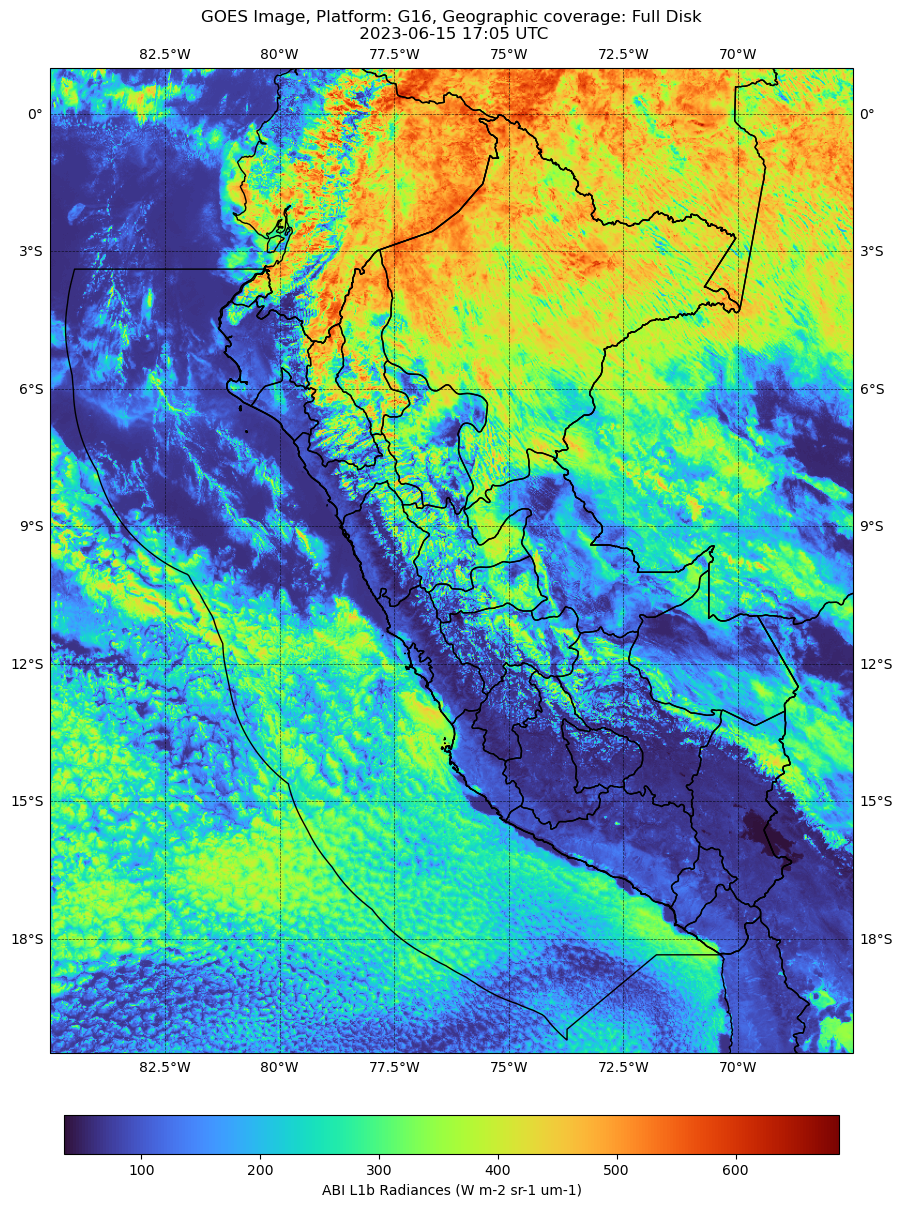

In [15]:
fig, ax = plt.subplots(figsize=(20, 16), subplot_kw=dict(projection=map_proj_dest))
# ax.set_global() # Global view
# ax.set_extent([LonLimits[0], LonLimits[1], LatLimits[0], LatLimits[1]]) # Image data limits
# ax.set_extent(PeruLimits_deg) # Peru limits
# ax.set_extent([-75.50, -75.25, -10,-9.5]) # Zoom to see pixels
# ax.set_extent(extent_deg)

# Plot the data variable values on the map
lon, lat = np.linspace(extent_deg[0],extent_deg[1],Nx), np.linspace(extent_deg[2],extent_deg[3],Ny)
# im1 = ax.pcolormesh(lon,lat,data_dst[:-1,:-1],cmap='turbo')
im1 = plt.imshow(data_dst,origin='lower',cmap='turbo',extent=extent_deg)
cbar = plt.colorbar(ax=ax, orientation='horizontal', shrink=0.5, pad=0.05)
cbar.set_label("{} ({})".format(data.title,dataVar.units))

# Add coastlines, countries, and Peru departments boundaries to the map
ax.add_geometries(gdf_countries['geometry'], crs=map_proj_pc, facecolor='none', edgecolor='black', linewidth=1)
# ax.add_geometries(gdf_maritime['geometry'], crs=map_proj_pc, facecolor='none', edgecolor='black', linewidth=1)
ax.add_geometries(gdf_peru_land['geometry'], crs=map_proj_pc, facecolor='none', edgecolor='black', linewidth=1)
ax.add_geometries(gdf_peru_sea['geometry'], crs=map_proj_pc, facecolor='none', edgecolor='black', linewidth=1)
ax.gridlines(draw_labels=True,lw=0.5,color='k',alpha=0.7,ls='--')

# Add the scale bar
# scale_bar = ScaleBar(dx=spatial_res/(25/3)*1000,units='km',length_fraction=0.2,location='lower right')
# ax.add_artist(scale_bar)
# Set the title of the map
ax.set_title("GOES Image, Platform: {}, Geographic coverage: {}\n {}".format(data.platform_ID,data.scene_id,str_ImgTime))
# Show the map
# ax.set_extent(PeruLimits_deg) # Peru limits
plt.show()

In [28]:
def goes_reproj(data, *args, fromto="ang2geo"):
# (Page 23) https://www.goes-r.gov/users/docs/PUG-L1b-vol3.pdf
# https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm#algorithm=
    # GOES-R projection info and retrieving relevant constants
    g16nc = data
    proj_info = g16nc['goes_imager_projection']
    lon_origin = proj_info.longitude_of_projection_origin
    lambda_0 = (lon_origin*np.pi)/180.0 # lat/lon calc routine from satellite radian angle vectors
    H = proj_info.perspective_point_height+proj_info.semi_major_axis
    r_eq = proj_info.semi_major_axis
    r_pol = proj_info.semi_minor_axis
    f = 1/proj_info.inverse_flattening
    e = np.sqrt(f*(2-f))
    
    if len(args) == 0:  # If only one argument is provided
        x_in = g16nc['x'].values[:]
        y_in = g16nc['y'].values[:]
        x_in,y_in = np.meshgrid(x_in,y_in)
        operation_over = "dataset"
    elif len(args) == 2:  # If two arguments are provided
        x_in, y_in = args
        operation_over = "vector"
    else:
        print("Invalid number of arguments.")
    
    if(fromto == "ang2geo"):
        print("Navigating from N/S Elevation Angle (y) and E/W Scanning Angle (x) to Geodetic Latitude (φ) and Longitude (λ)")
        # create meshgrid filled with radian angles

        a_var = np.power(np.sin(x_in),2.0) + (np.power(np.cos(x_in),2.0)*(np.power(np.cos(y_in),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_in),2.0))))
        b_var = -2.0*H*np.cos(x_in)*np.cos(y_in)
        c_var = (H**2.0)-(r_eq**2.0)

        r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)

        s_x = r_s*np.cos(x_in)*np.cos(y_in)
        s_y = - r_s*np.sin(x_in)
        s_z = r_s*np.cos(x_in)*np.sin(y_in)

        lat_rad = (np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
        lon_rad = (lambda_0 - np.arctan(s_y/(H-s_x)))
        
        lon_deg, lat_deg = lon_rad*(180.0/np.pi), lat_rad*(180.0/np.pi)
        return lon_deg, lat_deg
    
    elif(fromto == "geo2ang"):
        print("Navigating from Geodetic Latitude (φ) and Longitude (λ) to N/S Elevation Angle (y) and E/W Scanning Angle (x)")
        lon_rad, lat_rad = x_in*(np.pi/180), y_in*(np.pi/180)
        
        phi_c = np.arctan(np.tan(lat_rad)*(r_pol/r_eq)**2)
        
        r_c = r_pol/np.sqrt(1 - (e*np.cos(phi_c))**2)
        
        s_x = H - r_c*np.cos(phi_c)*np.cos(lon_rad - lambda_0)
        s_y = -r_c*np.cos(phi_c)*np.sin(lon_rad - lambda_0)
        s_z = r_c*np.sin(phi_c)
        
        y_rad = np.arctan(s_z/s_x)
        x_rad = np.arcsin(-s_y/np.sqrt(s_x**2 + s_y**2 + s_z**2))
        
        print("phi_c = {}\n r_c = {}\n s_x = {}\n s_y = {}\n s_z = {}".format(phi_c,r_c,s_x,s_y,s_z))
        return x_rad, y_rad
    
    else: print("fromto input should be 'ang2geo' or 'geo2ang'")
    
lon_deg,lat_deg = goes_reproj(data)
lon = np.linspace(np.nanmin(lon_deg),np.nanmax(lon_deg),Nx)

# RGB True Color GOES Images

In [32]:
RGBFilePath = os.path.join(destination_path,satellite,year, month, day, product,hour)
RGBchannels = ['C01', 'C02', 'C03']
for i in range(np.size(RGBchannels)):
    files = os.listdir(os.path.join(RGBFilePath,RGBchannels[i]))
    display(files)
    selected_index = 0

['OR_ABI-L1b-RadF-M6C01_G16_s20231661700209_e20231661709517_c20231661709565.nc',
 'OR_ABI-L1b-RadF-M6C01_G16_s20231661710209_e20231661719517_c20231661719566.nc',
 'OR_ABI-L1b-RadF-M6C01_G16_s20231661720209_e20231661729517_c20231661729559.nc',
 'OR_ABI-L1b-RadF-M6C01_G16_s20231661730209_e20231661739517_c20231661739561.nc',
 'OR_ABI-L1b-RadF-M6C01_G16_s20231661740209_e20231661749517_c20231661749565.nc',
 'OR_ABI-L1b-RadF-M6C01_G16_s20231661750209_e20231661759517_c20231661759564.nc']

['OR_ABI-L1b-RadF-M6C02_G16_s20231661700209_e20231661709517_c20231661709560.nc',
 'OR_ABI-L1b-RadF-M6C02_G16_s20231661710209_e20231661719517_c20231661719555.nc',
 'OR_ABI-L1b-RadF-M6C02_G16_s20231661720209_e20231661729517_c20231661729568.nc',
 'OR_ABI-L1b-RadF-M6C02_G16_s20231661730209_e20231661739517_c20231661739557.nc',
 'OR_ABI-L1b-RadF-M6C02_G16_s20231661740209_e20231661749517_c20231661749555.nc',
 'OR_ABI-L1b-RadF-M6C02_G16_s20231661750209_e20231661759517_c20231661759546.nc']

['OR_ABI-L1b-RadF-M6C03_G16_s20231661700209_e20231661709517_c20231661709571.nc',
 'OR_ABI-L1b-RadF-M6C03_G16_s20231661710209_e20231661719517_c20231661719569.nc',
 'OR_ABI-L1b-RadF-M6C03_G16_s20231661720209_e20231661729517_c20231661729571.nc',
 'OR_ABI-L1b-RadF-M6C03_G16_s20231661730209_e20231661739517_c20231661739565.nc',
 'OR_ABI-L1b-RadF-M6C03_G16_s20231661740209_e20231661749517_c20231661749562.nc',
 'OR_ABI-L1b-RadF-M6C03_G16_s20231661750209_e20231661759517_c20231661759553.nc']

In [17]:
# Define the file name
FileName = files[selected_index]
FullFilePath = os.path.join(FilePath,FileName)

# Load the data using the xarray package
data = xr.open_dataset(FullFilePath, engine='netcdf4')
varname = list(data.data_vars.keys())[0]
RedChannel = data[varname].values
RedChannel

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

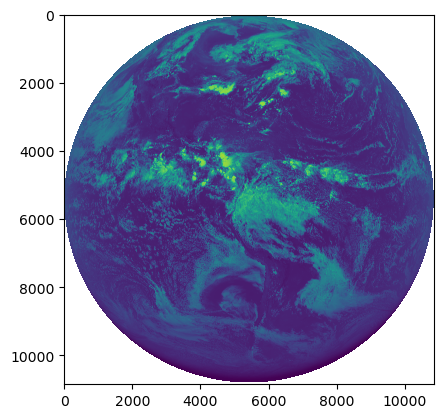

In [18]:
plt.imshow(RedChannel)

In [34]:
# You can create a list of number strings by using: [f"{i:02}" for i in range(13)]
destination_path = '.\\GOESimages\\'
bucket = 'noaa-goes16'
satellite = bucket[re.search('noaa-',bucket).end():]
day, month, year = '15', '06', '2023' # Date in dd/mm/yyyy format
hour = '17' # UTC, should be a string number between '00' and '23'
product=['ABI-L2-DSRF','ABI-L2-ACMF','ABI-L2-DMWF'] # Product to select
product0 = product[0]
domain = product0[-1]
channel=['C01','C02','C03'] # Number of band to select between 'C01' and 'C16'

FilePath = os.path.join(destination_path,satellite,year, month, day, product0,hour)
if ( product0[:-1] == "ABI-L1b-Rad") or (product0[:-1] == "ABI-L2-CMIP") :
    FilePath = os.path.join(FilePath,channel[0])
FilePath

'.\\GOESimages\\goes16\\2023\\06\\15\\ABI-L2-DSRF\\17'

In [35]:
files = os.listdir(FilePath)
display(files)

['OR_ABI-L2-DSRF-M6_G16_s20231661700209_e20231661709517_c20231661725585.nc']

In [36]:
# Create dropdown widget with index values of files list
file_selector = widgets.Dropdown(
    options=list(range(len(files))),
    value=0,
    description='Select file:',
)

# Define function to display selected file
def on_file_select(change):
    global selected_index
    selected_index = change['new']
    print(f'Selected file: {files[selected_index]}')

# Call function to display initial file
on_file_select({'new': file_selector.value})

# Link widget selection to function call
file_selector.observe(on_file_select, names='value')
display(file_selector)

Selected file: OR_ABI-L2-DSRF-M6_G16_s20231661700209_e20231661709517_c20231661725585.nc


Dropdown(description='Select file:', options=(0,), value=0)

In [37]:
# Define the file name
FileName = files[selected_index]
FullFilePath = os.path.join(FilePath,FileName)
# FullFilePath = r'C:/Users/germa/My Drive/Laptop Germain/Proyectos/CTIC/GOESimages/goes16/2018/03/22/ABI-L2-CMIPF/12/OR_ABI-L2-CMIPF-M3C01_G16_s20180811200448_e20180811211215_c20180811211282.nc'

# Load the data using the xarray package
data = xr.open_dataset(FullFilePath, engine='netcdf4')
data

<xarray.Dataset>
Dimensions:                                 (lat: 326, lon: 326,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             number_of_LZA_bounds: 2,
                                             number_of_SZA_bounds: 2,
                                             number_of_wavelength_bounds: 2)
Coordinates:
    t                                       datetime64[ns] ...
  * lat                                     (lat) float64 81.25 80.75 ... -81.25
  * lon                                     (lon) float64 -156.2 -155.8 ... 6.25
    lat_image                               float32 ...
    lon_image                               float32 ...
    retrieval_local_zenith_angle            float32 ...
    quantitative_local_zenith_angle         float32 ...
    retrieval_solar_zenith_angle            float32 ...
    quantitative_solar_zenith_angle         float32 ...
    dsr_product_wavelength                  float32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds,
                                number_of_wavelength_bounds
Data variables: (12/32)
    DSR                                     (lat, lon) float32 ...
    DQF                                     (lat, lon) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    goes_lat_lon_projection                 int32 ...
    lat_image_bounds                        (number_of_image_bounds) float32 ...
    lon_image_bounds                        (number_of_image_bounds) float32 ...
    ...                                      ...
    std_dev_dsr                             float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    algorithm_dynamic_input_data_container  int32 ...
    processing_parm_version_container       int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2023-06-15T17:00:20.9Z
    time_coverage_end:         2023-06-15T17:09:51.7Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        70129352-09f1-4271-8a20-420ca3168b77

In [39]:
varname = list(data.data_vars.keys())[0]
dataVar = data[varname]

ImgTime = data.t.values
ImgTime = utc.localize(datetime.utcfromtimestamp(ImgTime.tolist()//10**9))
str_ImgTime = ImgTime.strftime('%Y-%m-%d %H:%M %Z')

spatial_res = data.attrs["spatial_resolution"].split()[0]
spatial_res = float(re.findall('\d+',spatial_res)[0])

LonCenter = data.geospatial_lat_lon_extent.geospatial_lon_center
LatCenter = data.geospatial_lat_lon_extent.geospatial_lat_center
LonLimits = np.array([data.geospatial_lat_lon_extent.geospatial_westbound_longitude, data.geospatial_lat_lon_extent.geospatial_eastbound_longitude])
LatLimits = np.array([data.geospatial_lat_lon_extent.geospatial_southbound_latitude, data.geospatial_lat_lon_extent.geospatial_northbound_latitude])
PeruLimits_deg = [-85, -67.5, -20.5, 1.0]
PeruLimits_rad = 0.15*np.array([PeruLimits_deg[0]/180, PeruLimits_deg[1]/180, PeruLimits_deg[2]/90, PeruLimits_deg[3]/90])

Lon = np.linspace(LonLimits[0],LonLimits[1],len(data.lon.values))
Lat = np.linspace(LatLimits[0],LatLimits[1],len(data.lat.values))
print("Variable name: {}\n"
      "Longitude Limits: {} \n"
      "Latitude Limits: {}\n"
      "(LonCenter,LatCenter): {}".format(varname,LonLimits,LatLimits,(LonCenter,LatCenter)))

Variable name: DSR
Longitude Limits: [-156.5    6.5] 
Latitude Limits: [-81.5  81.5]
(LonCenter,LatCenter): (-75.0, 0.0)


In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib_scalebar.scalebar import ScaleBar

# Define the projection for the map
map_proj_ortho = ccrs.Orthographic(central_longitude=LonCenter, central_latitude=LatCenter)
map_proj_pc = ccrs.PlateCarree()
map_proj_geos = ccrs.Geostationary(
                central_longitude=gproj.longitude_of_projection_origin,
                satellite_height=gproj.perspective_point_height,
                sweep_axis=gproj.sweep_angle_axis,
                globe=ccrs.Globe(ellipse='sphere', # 'sphere', 'WGS84'
                                semimajor_axis=gproj.semi_major_axis, 
                                semiminor_axis=gproj.semi_minor_axis))
map_proj_dest = map_proj_pc

# Create a new figure and axes for the map
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=map_proj_dest))
# ax.set_extent(PeruLimits_deg) # Peru limits
extent_deg = ax.get_extent()
im = ax.imshow(dataVar.values, origin='upper', transform=map_proj_geos,cmap='turbo')
plt.close()
data_dst = im.get_array().data
Ny, Nx = data_dst.shape
print(dataVar.values.shape)
print("(Nx, Ny) = ({}, {})".format(Nx,Ny))

(326, 326)
(Nx, Ny) = (1500, 750)


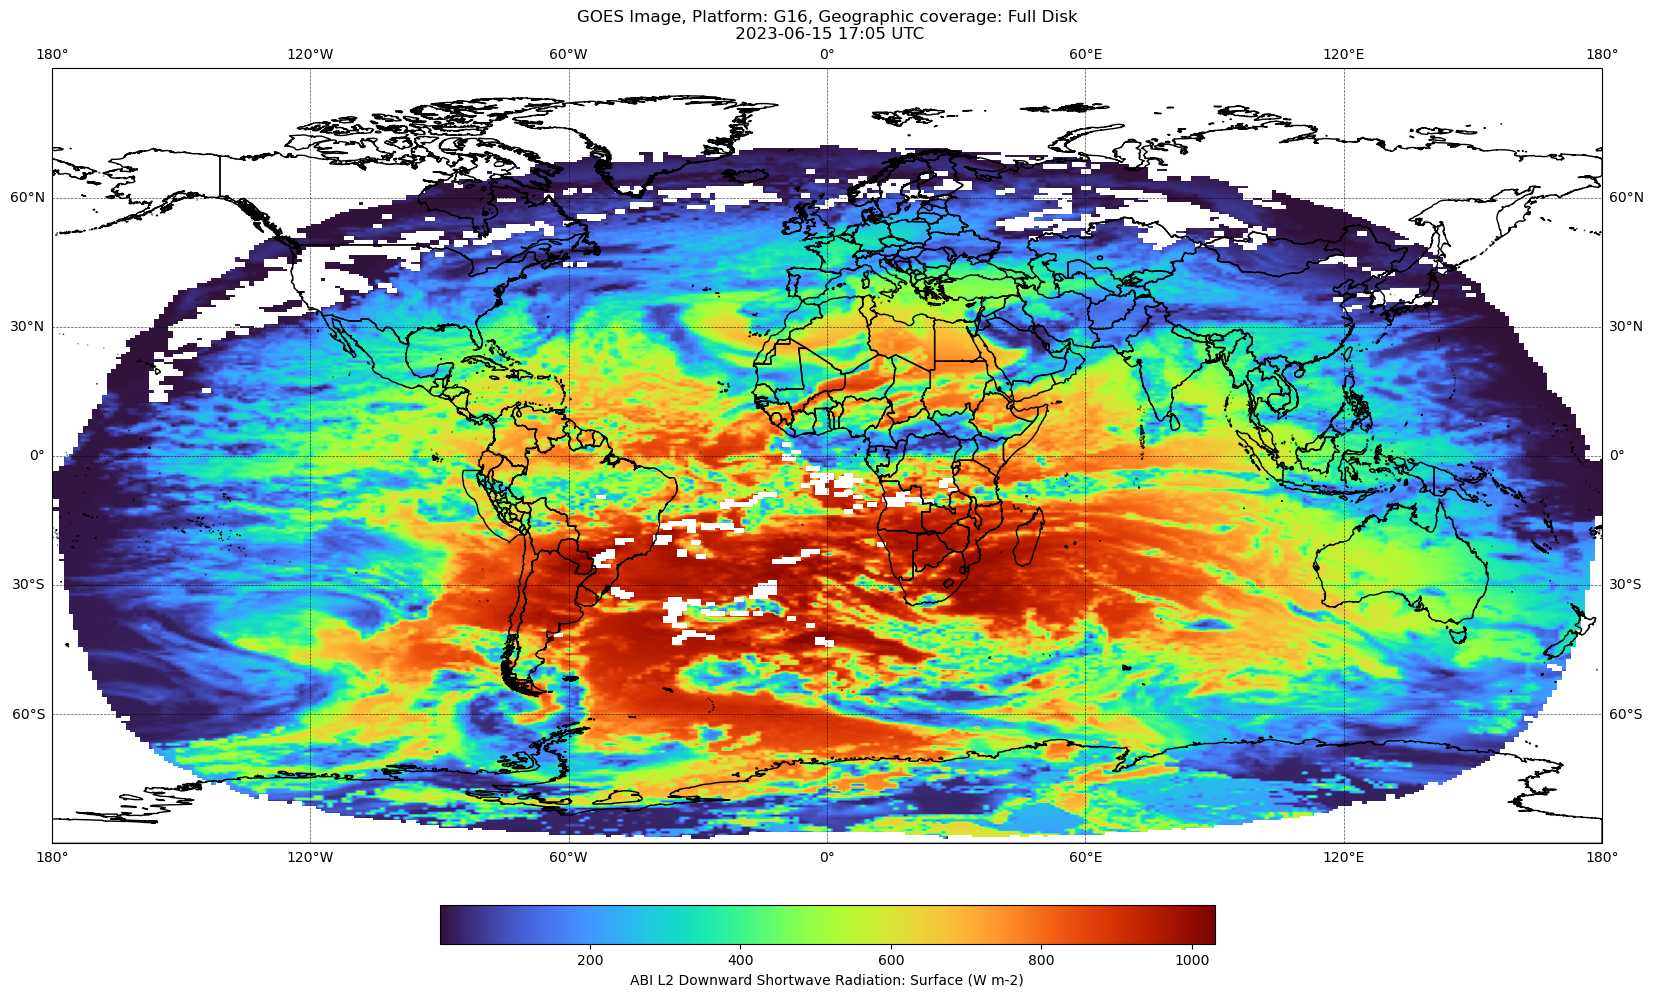

In [52]:
fig, ax = plt.subplots(figsize=(20, 16), subplot_kw=dict(projection=map_proj_dest))
# ax.set_global() # Global view
# ax.set_extent([LonLimits[0], LonLimits[1], LatLimits[0], LatLimits[1]]) # Image data limits
# ax.set_extent(PeruLimits_deg) # Peru limits
# ax.set_extent([-75.50, -75.25, -10,-9.5]) # Zoom to see pixels
# ax.set_extent(extent_deg)

# Plot the data variable values on the map
lon, lat = np.linspace(extent_deg[0],extent_deg[1],Nx), np.linspace(extent_deg[2],extent_deg[3],Ny)
# im1 = ax.pcolormesh(lon,lat,data_dst[:-1,:-1],cmap='turbo')
im1 = plt.imshow(data.DSR.values,origin='lower',cmap='turbo',extent=extent_deg)
cbar = plt.colorbar(ax=ax, orientation='horizontal', shrink=0.5, pad=0.05)
cbar.set_label("{} ({})".format(data.title,dataVar.units))

# Add coastlines, countries, and Peru departments boundaries to the map
ax.add_geometries(gdf_countries['geometry'], crs=map_proj_pc, facecolor='none', edgecolor='black', linewidth=1)
# ax.add_geometries(gdf_maritime['geometry'], crs=map_proj_pc, facecolor='none', edgecolor='black', linewidth=1)
ax.add_geometries(gdf_peru_land['geometry'], crs=map_proj_pc, facecolor='none', edgecolor='black', linewidth=1)
ax.add_geometries(gdf_peru_sea['geometry'], crs=map_proj_pc, facecolor='none', edgecolor='black', linewidth=1)
ax.gridlines(draw_labels=True,lw=0.5,color='k',alpha=0.7,ls='--')

# Add the scale bar
# scale_bar = ScaleBar(dx=spatial_res/(25/3)*1000,units='km',length_fraction=0.2,location='lower right')
# ax.add_artist(scale_bar)
# Set the title of the map
ax.set_title("GOES Image, Platform: {}, Geographic coverage: {}\n {}".format(data.platform_ID,data.scene_id,str_ImgTime))
# Show the map
# ax.set_extent(PeruLimits_deg) # Peru limits
plt.show()

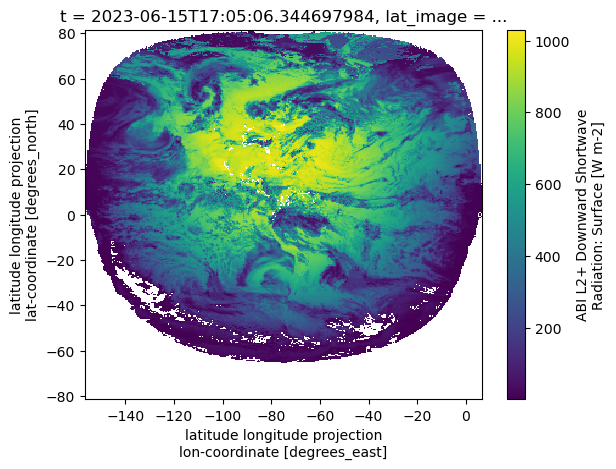

In [50]:
data.DSR.plot()